## Hotel and activity coordinates

In [1]:
# 导入必要的库
import gurobipy as gp
import math
from gurobipy import Model, GRB, quicksum, tupledict
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
Start = (50,50) # Hotel coordinates
points = [(Start)] #coordinates of all activities
Start_id = 0 # Hotel idendifier
points += [(17, 72), (97, 8), (32, 15), (63, 97), (57, 60), (83, 48), (100, 26), (12, 62), (3, 49), (55, 77), 
          (97, 98), (0, 89), (57, 34), (92, 29), (75, 13), (40, 3), (2, 3), (83, 69), (1, 48), (87, 27), 
          (54, 92), (3, 67), (28, 97), (56, 63), (70, 29), (44, 29), (86, 28), (97, 58), (37, 2), (53, 71), 
          (82, 12), (23, 80), (92, 37), (15, 95), (42, 92), (91, 64), (54, 64), (85, 24), (38, 36), (75, 63), 
          (64, 50), (75, 4), (61, 31), (95, 51), (53, 85), (22, 46), (70, 89), (99, 86), (94, 47), (11, 56)]

n = len(points) # total number of nodes

## Distance and time from node i to node j

In [3]:
# Distance between two activities (i,j)
distance = {(i, j):
        math.sqrt(sum((points[i][k]-points[j][k])**2 for k in range(2)))
        for i in range(n) for j in range(n)}

## Utility or reward to do an activity

In [4]:
reward = {46: 43.15033999478041, 50: 20.948831277616726, 8: 17.263102417797167, 1: 21.18033988749895, 
          32: 27.72004514666935, 23: 30.872991584635255, 34: 29.308440859369416, 12: 38.35909773257803, 
          22: 40.20360331117452, 9: 20.23606797749979, 19: 47.24717771720739, 17: 80.0253925397308, 
          29: 38.176560460191574, 16: 17.584482762024336, 3: 32.86129401644173, 26: 27.65863337187866, 
          39: 27.65863337187866, 41: 33.1049731745428, 6: 36.99351699454112, 36: 26.373825194236886, 
          28: 15.765391263519088, 44: 11.403215514898179, 49: 14.32114465280323, 33: 21.014692853577536, 
          27: 14.939759452009628, 38: 7.728656901081649, 20: 8.990716082598492, 14: 13.929168552452033, 
          7: 26.792291336212188, 2: 33.77246228715468, 31: 26.154320508994672, 42: 19.63014581273465, 
          15: 25.76305461424021, 25: 25.982599071533098, 43: 14.219544457292887, 13: 22.46424919657298, 
          40: 38.17800560721074, 18: 33.3452350598575, 48: 35.510760120453945, 11: 40.626024002111855, 
          47: 39.090644754250064, 4: 20.92577595372165, 21: 22.295630140987, 35: 25.038404810405297, 
          45: 21.28461606164062, 10: 14.57076657157208, 30: 13.395623132202235, 37: 9.307135789365265, 
          24: 5.39834563766817, 5: 15.368833275902082}
reward[Start_id] = 0

## Time windows

In [5]:
early = {46: 0, 50: 0, 8: 12, 1: 22, 32: 39, 23: 53, 34: 69, 12: 91, 22: 109, 9: 111, 19: 156, 17: 191, 29: 194, 16: 209, 3: 227, 26: 236, 39: 255, 41: 274, 6: 292, 36: 300, 28: 308, 44: 312, 49: 322, 33: 333, 27: 337, 38: 340, 20: 346, 14: 354, 7: 373, 2: 388, 31: 399, 42: 408, 15: 425, 25: 434, 43: 439, 13: 456, 40: 466, 18: 490, 48: 502, 11: 530, 47: 541, 4: 551, 21: 563, 35: 576, 45: 584, 10: 591, 30: 598, 37: 600, 24: 603, 5: 615}
late = {46: 35, 50: 41, 8: 53, 1: 63, 32: 80, 23: 94, 34: 110, 12: 132, 22: 150, 9: 152, 19: 197, 17: 232, 29: 235, 16: 250, 3: 268, 26: 277, 39: 296, 41: 315, 6: 333, 36: 341, 28: 349, 44: 353, 49: 363, 33: 374, 27: 378, 38: 381, 20: 387, 14: 395, 7: 414, 2: 429, 31: 440, 42: 449, 15: 466, 25: 475, 43: 480, 13: 497, 40: 507, 18: 531, 48: 543, 11: 571, 47: 582, 4: 592, 21: 604, 35: 617, 45: 625, 10: 632, 30: 639, 37: 641, 24: 644, 5: 656}


## Groups of activities

In [6]:
Dining = [i for i in range(len(points)) if i % 3 == 0 and i != 0]
Sightseeing = [i for i in range(len(points)) if i % 3 == 1]
Recreational = [i for i in range(len(points)) if i % 3 == 2]
G = [Dining, Sightseeing, Recreational]

In [7]:
print(Sightseeing)

[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49]


## Budget

In [8]:
B = 300
cost = {e:2 for e in range(1,n)}


In [9]:

def optimize_tour(n, Start_id, points, reward, cost, B, distance, early, late, Dining, Sightseeing, Recreational):
    m = gp.Model()

    # Decision variables
    x = m.addVars(n, vtype=GRB.BINARY, name="x")  # Activity selection
    y = tupledict({(i, j): m.addVar(vtype=GRB.BINARY, name=f'y[{i},{j}]') for i in range(n) for j in range(n)})  # Transitions
    t = m.addVars(n, vtype=GRB.CONTINUOUS, lb=0, name="t")  # Time of arrival at each activity

    # Objective function
    m.setObjective(
        quicksum(reward[i] * x[i] for i in range(n)) -
        quicksum(cost[i] * x[i] for i in range(1, n)) -
        quicksum(distance[i, j] * y[i, j] for i in range(n) for j in range(n) if i != j),
        GRB.MAXIMIZE
    )

    # Constraints
    m.addConstrs((y[i, i] == 0 for i in range(n)), name="no_self_loop")
    for i in range(n):
        inflow = quicksum(y[j, i] for j in range(n))
        outflow = quicksum(y[i, j] for j in range(n))
        m.addConstr(inflow == outflow, name=f"flow_conserv_{i}")
        m.addConstr(x[i] == inflow, name=f"activity_{i}_inflow")
        m.addConstr(x[i] == outflow, name=f"activity_{i}_outflow")

    m.addConstr(
        quicksum(cost[i] * x[i] for i in range(1, n)) +
        quicksum(distance[i, j] * y[i, j] for i in range(n) for j in range(n) if i != j) <= B,
        "Budget"
    )

    for i in range(1, n):
        m.addGenConstrIndicator(x[i], True, t[i] >= early[i], name=f"time_window_start_{i}")
        m.addGenConstrIndicator(x[i], True, t[i] <= late[i], name=f"time_window_end_{i}")

    for i in range(n):
        for j in range(n):
            if i != j:
                m.addGenConstrIndicator(y[i, j], True, t[j] >= (0 if i == Start_id else t[i] + distance[i, j]), name=f"transit_time_{i}_{j}")

    # Specific activity sequence constraints
    for i in range(1, n):
        if i in Recreational or i in Sightseeing:
            m.addConstr(quicksum(y[i, j] for j in Dining) >= x[i], name=f"Dining_follows_{i}")

    # Group selection constraints
    m.addConstr(quicksum(x[i] for i in Recreational) == 1, "One_per_Recreational")
    m.addConstr(quicksum(x[i] for i in Sightseeing) == 1, "One_per_Sightseeing")
    m.addConstr(quicksum(x[i] for i in Dining) == 2, "Two_Dining")

    # Start and end at the hotel
    m.addConstr(quicksum(y[Start_id, j] for j in range(n)) == 1, "Start_from_hotel")
    m.addConstr(quicksum(y[i, Start_id] for i in range(n)) == 1, "End_at_hotel")

    # Solving the model
    m.optimize()

    # Extracting the path if the solution is optimal
    path = [Start_id]
    if m.status == GRB.OPTIMAL:
        # Determine the starting point
        current = Start_id
        visited = set()
        for _ in range(n):
            # Select the next activity based on the transition variable y
            next_activities = [j for j in range(n) if y[current, j].X > 0.5 and j not in visited]
            if not next_activities:
                break
            next_activity = next_activities[0]
            path.append(next_activity)
            visited.add(next_activity)
            current = next_activity

    return path, m.objVal if m.status == GRB.OPTIMAL else None
# Call the function and capture the result
tour, net_reward = optimize_tour(n, Start_id, points, reward, cost, B, distance, early, late, Dining, Sightseeing, Recreational)
print(tour)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 21.6.0 21H1123)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 244 rows, 2703 columns and 13785 nonzeros
Model fingerprint: 0x5c08b753
Model has 2650 general constraints
Variable types: 51 continuous, 2652 integer (2652 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
  GenCon rhs range [1e+00, 7e+02]
  GenCon coe range [1e+00, 1e+00]
Presolve added 654 rows and 0 columns
Presolve removed 0 rows and 1181 columns
Presolve time: 0.09s
Presolved: 898 rows, 1522 columns, 5819 nonzeros
Presolved model has 658 SOS constraint(s)
Variable types: 702 continuous, 820 integer (820 binary)
Found heuristic solution: objective -23.6659451

Root rel

In [ ]:
budget = B
cost[0]=0
cost_dict = cost

In [ ]:
def heuristic_itinerary(points, distance, start_id, cost, budget, early, late, Dining, Recreational, Sightseeing, reward, n):
    current_position = start_id
    path = [start_id]  # Start at the hotel
    total_cost = 0
    total_reward = reward[start_id]  # Initialize reward with the start point's reward
    visited = {start_id}  # Keep track of visited points
    activities_done = {'Dining': 0, 'Recreational': 0, 'Sightseeing': 0}

    def select_activity(activities, required_type=None):
        best_activity = None
        best_value = float('-inf')
        for activity in activities:
            if activity in visited or (current_position, activity) not in distance:
                continue
            projected_cost = total_cost + cost.get(activity, 0) + distance[(current_position, activity)]
            if projected_cost > budget or not (total_cost + distance[(current_position, activity)] <= late.get(activity, float('inf'))):
                continue
            if required_type and activity_type(activity) != required_type:
                continue  # Skip if activity type does not match the required type
            value = reward[activity] - projected_cost
            if value > best_value:
                best_activity = activity
                best_value = value
        return best_activity

    def add_activity(activity):
        nonlocal total_cost, current_position, total_reward
        if activity:
            path.append(activity)
            visited.add(activity)
            activity_cost = cost.get(activity, 0) + distance[(current_position, activity)]
            total_cost += activity_cost
            total_reward += reward[activity]
            current_position = activity
            activities_done[activity_type(activity)] += 1
            print(f"Added {activity_type(activity)} {activity}: Cost={activity_cost}, Total Cost={total_cost}")

    def activity_type(activity):
        if activity in Dining:
            return 'Dining'
        elif activity in Recreational:
            return 'Recreational'
        elif activity in Sightseeing:
            return 'Sightseeing'
        return None

    # First main activity (either Recreational or Sightseeing)
    first_main_activity = select_activity(Recreational + Sightseeing)
    if first_main_activity:
        add_activity(first_main_activity)

    # First dining activity
    first_dining = select_activity(Dining, required_type='Dining')
    if first_dining:
        add_activity(first_dining)
    else:
        print("No suitable first dining activity found within constraints.")

    # Second main activity (other type than first)
    other_type = 'Recreational' if activity_type(first_main_activity) == 'Sightseeing' else 'Sightseeing'
    second_main_activity = select_activity([x for x in (Recreational + Sightseeing) if x != first_main_activity], required_type=other_type)
    if second_main_activity:
        add_activity(second_main_activity)

    # Second dining activity
    second_dining = select_activity(Dining, required_type='Dining')
    if second_dining:
        add_activity(second_dining)
    else:
        print("No suitable second dining activity found within constraints.")

    # Return to the hotel
    if current_position != start_id:
        path.append(start_id)
        return_to_hotel_cost = distance[(current_position, start_id)]
        total_cost += return_to_hotel_cost
        print(f"Returning to start: Cost={return_to_hotel_cost}, Total Cost={total_cost}")

    net_reward = total_reward - total_cost
    return path, net_reward

# Example call to the function with placeholders for actual data
path, net_reward = heuristic_itinerary(points, distance, Start_id, cost, budget, early, late, Dining, Recreational, Sightseeing, reward, n)
print("Path:", path)
print("Net Utility:", net_reward)


Added Recreational 41: Cost=16.0, Total Cost=16.0
Added Dining 6: Cost=21.1049731745428, Total Cost=37.1049731745428
Added Sightseeing 40: Cost=19.0, Total Cost=56.1049731745428
Added Dining 18: Cost=12.0, Total Cost=68.1049731745428
Returning to start: Cost=38.07886552931954, Total Cost=106.18383870386235
Path: [0, 41, 6, 40, 18, 0]
Net Utility: 35.437892132289804


In [ ]:
def figure(t, points, Dining, Sightseeing, Recreational, Start_id, name):
    # plt.figure(figsize=(8, 5))
    ax = plt.gca()

    ax.set_xlim((-5, 105))
    ax.set_ylim((-5, 105))

    for idx, point in enumerate(points):
        if idx in Dining:
            ax.plot(point[1], point[0], 'ro', label='Dining' if idx == Dining[0] else "")
        elif idx in Sightseeing:
            ax.plot(point[1], point[0], 'yo', label='Sightseeing' if idx == Sightseeing[0] else "")
        elif idx in Recreational:
            ax.plot(point[1], point[0], 'go', label='Recreational' if idx == Recreational[0] else "")

    ax.plot(points[Start_id][1], points[Start_id][0], 's', color='black', label='Start')

    x_path = [points[i][1] for i in t] + [points[t[0]][1]]
    y_path = [points[i][0] for i in t] + [points[t[0]][0]]
    ax.plot(x_path, y_path, 'k--', label='Path')

    plt.legend()
    plt.savefig(name)
    plt.show()
    

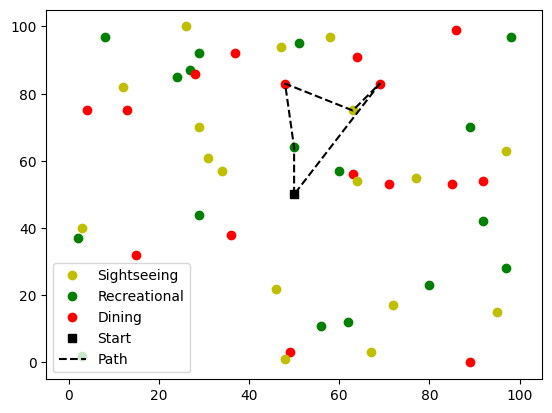

In [ ]:
figure(tour, points, Dining, Sightseeing, Recreational, Start_id,'foo.png')

Added Recreational 17: Cost=69.17886572427373, Total Cost=69.17886572427373
Added Dining 3: Cost=34.31098884280702, Total Cost=103.48985456708076
Added Sightseeing 19: Cost=47.27692569068709, Total Cost=150.76678025776783
Added Dining 39: Cost=40.897300677553446, Total Cost=191.6640809353213
Returning to start: Cost=18.439088914585774, Total Cost=210.10316984990706
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 21.6.0 21H1123)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 244 rows, 2703 columns and 13785 nonzeros
Model fingerprint: 0xb5c9ade4
Model has 2650 general constraints
Variable types: 51 continuous, 2652 integer (2652 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
  GenCon rhs range [1e+00, 7e+02]
  GenCon coe range [1e+00, 1e+00]
Presolve added 654 rows and 

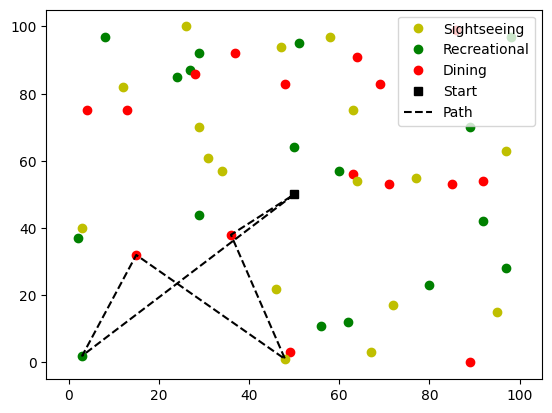

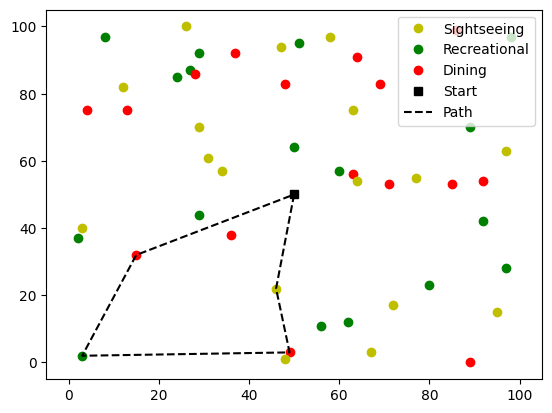

In [ ]:
# Big Reward Scenario
big_reward = {k: v * 2 for k, v in reward.items()}
path_h_big_reward, net_reward_h_big_reward = heuristic_itinerary(points, distance, Start_id, cost, B, early, late, Dining, Recreational, Sightseeing, big_reward, n)
path_o_big_reward, net_reward_o_big_reward = optimize_tour(n, Start_id, points, big_reward, cost, B, distance, early, late, Dining, Sightseeing, Recreational)

print("---Big Reward Scenario---")
print("Heuristic Itinerary Path:", path_h_big_reward)
print("Heuristic Itinerary Net Reward:", net_reward_h_big_reward)
print("Optimize Tour Path:", path_o_big_reward)
print("Optimize Tour Net Reward:", net_reward_o_big_reward)
figure(path_h_big_reward, points, Dining, Sightseeing, Recreational, Start_id, 'Big_Reward_Heuristic.png')
figure(path_o_big_reward, points, Dining, Sightseeing, Recreational, Start_id, 'Big_Reward_Optimize.png')




Added Sightseeing 46: Cost=30.284271247461902, Total Cost=30.284271247461902
Added Dining 39: Cost=20.867962264113206, Total Cost=51.152233511575105
Added Recreational 17: Cost=50.83646178829912, Total Cost=101.98869529987422
Added Dining 3: Cost=34.31098884280702, Total Cost=136.29968414268126
Returning to start: Cost=39.35733730830886, Total Cost=175.6570214509901
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 21.6.0 21H1123)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 244 rows, 2703 columns and 13785 nonzeros
Model fingerprint: 0xdcf450f2
Model has 2650 general constraints
Variable types: 51 continuous, 2652 integer (2652 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
  GenCon rhs range [1e+00, 7e+02]
  GenCon coe range [1e+00, 1e+00]
Presolve added 654 rows and

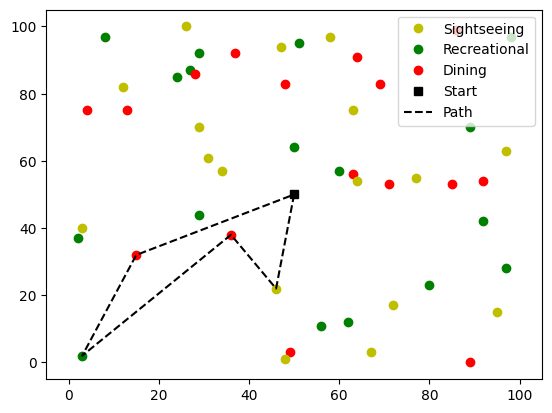

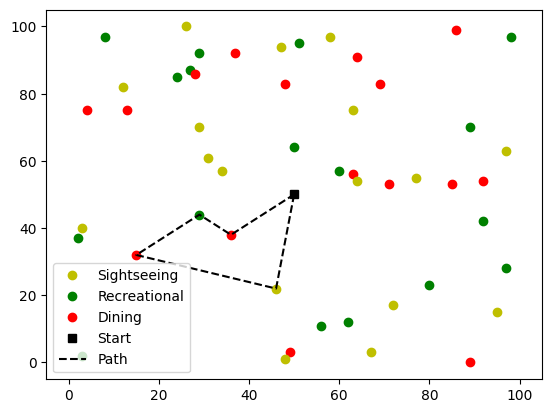

In [ ]:
# Several Big Rewards Scenario
several_big_reward = reward.copy()
keys_to_increase = list(reward.keys())[:5]
for key in keys_to_increase:
    several_big_reward[key] *= 6

path_h_several_big_rewards, net_reward_h_several_big_rewards = heuristic_itinerary(points, distance, Start_id, cost, B, early, late, Dining, Recreational, Sightseeing, several_big_reward, n)
path_o_several_big_rewards, net_reward_o_several_big_rewards = optimize_tour(n, Start_id, points, several_big_reward, cost, B, distance, early, late, Dining, Sightseeing, Recreational)

print("---Several Big Rewards Scenario---")
print("Heuristic Itinerary Path:", path_h_several_big_rewards)
print("Heuristic Itinerary Net Reward:", net_reward_h_several_big_rewards)
print("Optimize Tour Path:", path_o_several_big_rewards)
print("Optimize Tour Net Reward:", net_reward_o_several_big_rewards)

figure(path_h_several_big_rewards, points, Dining, Sightseeing, Recreational, Start_id, 'Several_Big_Rewards_Heuristic.png')
figure(path_o_several_big_rewards, points, Dining, Sightseeing, Recreational, Start_id, 'Several_Big_Rewards_Optimize.png')



In [ ]:
keys_to_increase

[46, 50, 8, 1, 32]

Added Recreational 41: Cost=16.0, Total Cost=16.0
Added Dining 6: Cost=21.1049731745428, Total Cost=37.1049731745428
Added Sightseeing 40: Cost=19.0, Total Cost=56.1049731745428
Added Dining 18: Cost=12.0, Total Cost=68.1049731745428
Returning to start: Cost=38.07886552931954, Total Cost=106.18383870386235
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 21.6.0 21H1123)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 244 rows, 2703 columns and 13785 nonzeros
Model fingerprint: 0x8ef62cfe
Model has 2650 general constraints
Variable types: 51 continuous, 2652 integer (2652 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
  GenCon rhs range [1e+00, 7e+02]
  GenCon coe range [1e+00, 1e+00]
Presolve added 75 rows and 0 columns
Presolve removed 0 rows and 2194 columns
Presolve t

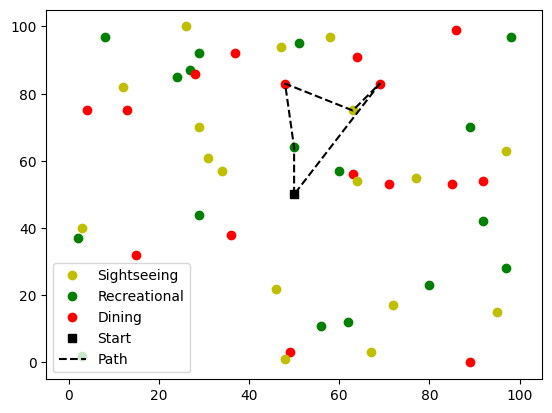

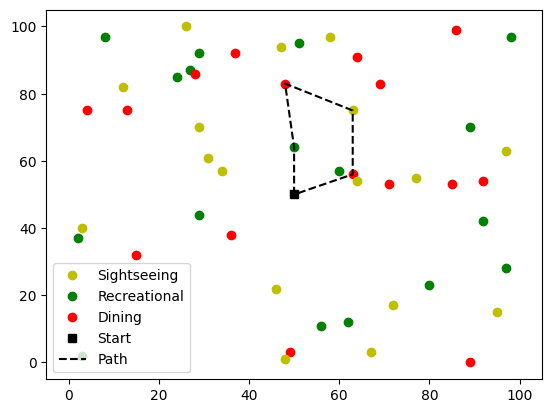

In [ ]:
# Limited Budget Scenario
limited_budget = B / 3

path_h_limited_budget, net_reward_h_limited_budget = heuristic_itinerary(points, distance, Start_id, cost, limited_budget, early, late, Dining, Recreational, Sightseeing, reward, n)
path_o_limited_budget, net_reward_o_limited_budget = optimize_tour(n, Start_id, points, reward, cost, limited_budget, distance, early, late, Dining, Sightseeing, Recreational)

print("---Limited Budget Scenario---")
print("Heuristic Itinerary Path:", path_h_limited_budget)
print("Heuristic Itinerary Net Reward:", net_reward_h_limited_budget)
print("Optimize Tour Path:", path_o_limited_budget)
print("Optimize Tour Net Reward:", net_reward_o_limited_budget)

figure(path_h_limited_budget, points, Dining, Sightseeing, Recreational, Start_id, 'Limited_Budget_Heuristic.png')
figure(path_o_limited_budget, points, Dining, Sightseeing, Recreational, Start_id, 'Limited_Budget_Optimize.png')




In [ ]:

# class Label:
#     parent = None
#     customer= None
#     cost = 0.0
#     time = 0.0
#     distance = 0
#     utility = 0
#     def __init__(self, l=None, node=0):
#         self.customer = node
#         if l:
#             self.cost = l.cost + distance[(l.customer, node)] + cost_dict[node]
#             self.time = resource_extension_T(l, node)
#             self.utility = l.utility + reward[node] - distance[(l.customer, node)] - cost_dict[node]
#             self.distance = l.distance + distance[(l.customer, node)]
            
#             activity_type = get_activity_type(node)
#             if activity_type:  # Ensure activity_type is not None before accessing the dictionary
#                 self.activities_count = dict(l.activities_count)
#                 self.activities_count[activity_type] = self.activities_count.get(activity_type, 0) + 1
#                 self.last_activity = activity_type
#             else:
#                 self.activities_count = dict(l.activities_count)
#                 self.last_activity = None
            
#         else:
#             self.activities_count = {'Dining': 0, 'Recreational': 0, 'Sightseeing': 0, 'Other': 0}
#             self.last_activity = None
#         self.parent = l



# def resource_extension_T(label, next_node):
#     # Assuming you have a function to calculate new time based on previous label and travel time to next_node
#     return label.time + distance[(label.customer, next_node)]  # Simple additive time increment

# def get_activity_type(node):
#     if node in Dining:
#         return 'Dining'
#     elif node in Recreational:
#         return 'Recreational'
#     elif node in Sightseeing:
#         return 'Sightseeing'
#     else:
#         return 'Other'

# def dominance(l1, l2):
#     """Returns true if l1 dominates l2"""
#     return l1.utility >= l2.utility 

# def feasible(l, i):
#     """Returns if extending from label l to node i is feasible."""
#     # Check if it's feasible to go to node i from label l
#     if l.customer == i:
#         return False
#     # ex 2.1: Time constraints
#     if distance[(l.customer, i)] + l.time > late[i]:
#         return False
#     # ex 2.2: Time constraints
#     if distance[(l.customer, i)] + l.time < early[i]:
#         return False
#     # Check if Dining happens after every activity
#     activity_type = get_activity_type(i)
#         # 确保回家前完成必要的活动数量
#     if i == Start_id:  # 假设 Start_id 是家的节点
#         if l.activities_count['Dining'] < 2 or l.activities_count['Recreational'] < 1 or l.activities_count['Sightseeing'] < 1:
#             return False
#     if activity_type == 'Dining':
#         if l.last_activity is not None and l.last_activity != 'Dining':
#             return False
#     # Check that only one activity per group of activities can be done
#     # 特定活动的次数限制
#     if activity_type == 'Dining':
#         if l.activities_count[activity_type] >= 2:  # Dining 可以进行最多两次
#             return False
#     elif activity_type in ['Recreational', 'Sightseeing']:
#         if l.activities_count[activity_type] >= 1:  # Recreational 和 Sightseeing 只能进行一次
#             return False

#     return True

# # Now let's redefine the labeling algorithm with included feasibility check
# import random

# def labeling_algorithm():
#     l0 = Label()
#     M = {(k, i): [] for k in range(n) for i in range(n)}
#     M[(0, Start_id)].append(l0)  # Initial label at the start node

#     for k in range(1, n):  # Number of nodes visited
#         for i in range(n):  # Current node
#             random_j_nodes = list(range(1, n))
#             random.shuffle(random_j_nodes)  # Randomize the order of nodes
#             for j in random_j_nodes:  # New node to extend to
#                 if j == i:
#                     continue
#                 for l in random.sample(M[(k-1, i)], len(M[(k-1, i)])):  # Randomize labels order
#                     if feasible(l, j):
#                         l2 = Label(l, j)
#                         dominated = False
#                         M_kj = M[(k, j)]
#                         random.shuffle(M_kj)  # Randomize the order of existing labels in M[k, j]
#                         for l1 in M_kj:
#                             if dominance(l1, l2):
#                                 dominated = True
#                                 break
#                             elif dominance(l2, l1):
#                                 M[(k, j)].remove(l1)
#                         if not dominated and (random.random() < 1 or len(M[(k, j)]) == 0):  # 95% chance to accept
#                             M[(k, j)].append(l2)

#     return best_label(M)


# def best_label(M):
#     best_l = None
#     highest_utility = float('-inf')

#     for k in range(1, n):
#         for i in range(1, n):
#             for l in M[(k, i)]:
#                 # 这里初始时 best_l 是 None，所以我们需要检查它是否被赋值
#                 if best_l is None:
#                     # 第一次赋值，没有东西可以比较，直接设置为当前标签
#                     best_l = l
#                     highest_utility = l.utility - distance[(l.customer, Start_id)]
#                 else:
#                     a = distance[(l.customer, Start_id)]
#                     b = distance[(best_l.customer, Start_id)]
#                     current_utility = l.utility - a
#                     if current_utility > highest_utility:
#                         best_l = l
#                         highest_utility = current_utility

#     if best_l is not None:
#         print("Best label found with utility: ", highest_utility)
#     else:
#         print("No valid label found.")

#     return best_l
